<a href="https://colab.research.google.com/github/puzis/llmnet/blob/main/Distil_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import AutoTokenizer, DistilBertModel, DistilBertConfig
import torch
import torch.nn as nn
from datasets import load_dataset
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'datasets'

In [ ]:
dataset = load_dataset("glue", "mrpc")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
hundred_inputs = []
token_arrays = []

for i in range(100):
    hundred_inputs.append(dataset['train']['sentence1'][i])
    tokens = tokenizer(dataset['train']['sentence1'][i], truncation=True, padding="max_length", return_tensors="pt")
    token_arrays.append(tokens)

In [ ]:
dataset = load_dataset("Amod/mental_health_counseling_conversations")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
hundred_inputs = []
token_arrays = []

for i in range(100):
    hundred_inputs.append(dataset['train']['Response'][i])
    tokens = tokenizer(dataset['train']['Response'][i], truncation=True, padding="max_length", return_tensors="pt")
    token_arrays.append(tokens)

In [ ]:
dataset = load_dataset("tweet_eval", "sentiment")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
hundred_inputs = []
token_arrays = []

for i in range(100):
    hundred_inputs.append(dataset['train']['text'][i])
    tokens = tokenizer(dataset['train']['text'][i], truncation=True, padding="max_length", return_tensors="pt")
    token_arrays.append(tokens)

In [ ]:
class SA_LayerNorm(nn.Module):
    def __init__(self, hidden_size):
        super(SA_LayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        return self.layer_norm(x)

class DistilBERT(nn.Module):
    def __init__(self, model_name_or_path="distilbert-base-uncased"):
        super(DistilBERT, self).__init__()
        self.config = DistilBertConfig.from_pretrained(model_name_or_path)
        self.distilbert = DistilBertModel.from_pretrained(model_name_or_path, config=self.config)

        # Adding SA_LayerNorm head for each transformer layer
        self.sa_layer_norms = nn.ModuleList([SA_LayerNorm(self.config.dim) for _ in range(self.config.num_hidden_layers)])

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        embedding_output = hidden_states

        k_values, v_values, q_values, out_lin_output, ffn_output, output_layer_norm, sa_layer_norm_output = [], [], [], [], [], [], []
        all_hidden_states = [hidden_states]

        for i, layer in enumerate(self.distilbert.transformer.layer):
            k_values.append(layer.attention.k_lin(hidden_states))
            v_values.append(layer.attention.v_lin(hidden_states))
            q_values.append(layer.attention.q_lin(hidden_states))

            out_lin_output.append(layer.attention.out_lin(hidden_states))

            ffn_out = layer.ffn(hidden_states)
            ffn_output.append(ffn_out)

            hidden_states = layer.output_layer_norm(ffn_out + hidden_states)
            output_layer_norm.append(hidden_states)

            # Applying SA_LayerNorm to the last hidden state for each transformer layer
            sa_layer_norm_output.append(self.sa_layer_norms[i](hidden_states))

            all_hidden_states.append(hidden_states)

        # Concatenate outputs along dim=0
        concatenated_output = torch.cat([
            embedding_output,
        ], dim=0)

        for i in range(len(self.distilbert.transformer.layer)):
            concatenated_output = torch.cat([
                concatenated_output,
                k_values[i],
                v_values[i],
                q_values[i],
                out_lin_output[i],
                output_layer_norm[i],
                sa_layer_norm_output[i],
                ffn_output[i]
            ], dim=0)

        return concatenated_output

In [ ]:
model = DistilBERT()

tensor = torch.empty(0)
for i in range(15):
  output = model(**token_arrays[i])
  output = output.reshape(768*43, 512)
  tensor = torch.cat((tensor, output), dim=1)

In [ ]:
corr = torch.corrcoef(tensor)

In [ ]:
plt.imshow(corr.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.savefig('mental-health.png')
plt.show()

In [ ]:
torch.save(corr, 'tensor.pt')

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [ ]:
rc = nx.rich_club_coefficient(G, normalized=False, seed=42)

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 10
keys = list(rc.keys())
values = list(rc.values())
plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Rich Club Plot')
plt.savefig('rich_club_plot-distilbert-tweet-20.png')
plt.show()

In [ ]:
tensor = torch.load('tensor.pt')

In [ ]:
def extract_edges_from_correlation_matrix(correlation_matrix, threshold):
    positive_mask = correlation_matrix > threshold
    negative_mask = correlation_matrix < -threshold
    edge_mask = positive_mask | negative_mask
    edges = torch.nonzero(edge_mask, as_tuple=False)
    edges = torch.unique(edges, dim=0)

    return edges

edges = extract_edges_from_correlation_matrix(tensor, threshold=0.5)

In [ ]:
src_nodes = edges[:, 0]
tgt_nodes = edges[:, 1]
non_self_loop_indices = src_nodes != tgt_nodes
filtered_edge_list = edges[non_self_loop_indices]

edges = filtered_edge_list.tolist()
G = nx.Graph()
G.add_edges_from(edges)

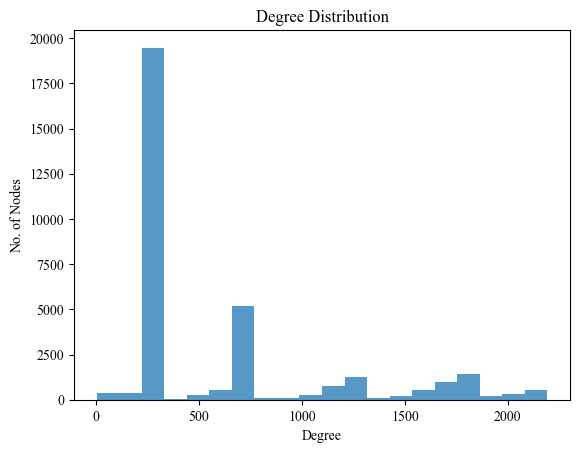

In [ ]:
degree_sequence = [d for n, d in G.degree()]
plt.hist(degree_sequence, bins=20, alpha=0.75)

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 10

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("No. of Nodes")

plt.savefig('degree-dist-distilbert-tweet-50.png')
plt.show()

Creating histogram...


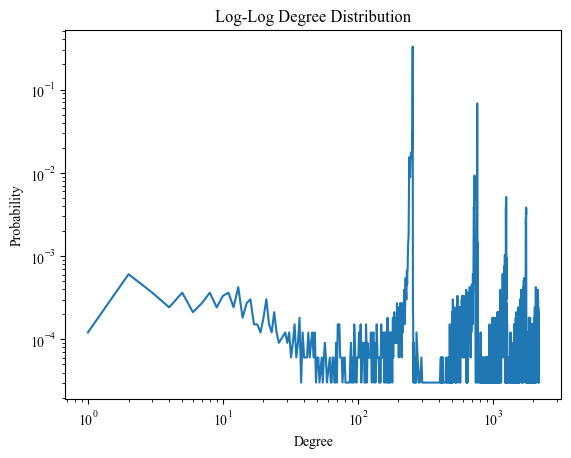

In [ ]:
import numpy as np
def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0, len(aux_y)).tolist()
    n_nodes = g.number_of_nodes()
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i] / n_nodes
    aux_x = [x for x, y in zip(aux_x, aux_y) if y > 0]
    aux_y = [y for y in aux_y if y > 0]
    plt.plot(aux_x, aux_y, markersize=100)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Log-Log Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency" if not normalized else "Probability")
    plt.savefig('log-log-degree-dist-distilbert-tweet-50.png')
    plt.show()

plot_degree_histogram(G)

Creating histogram...


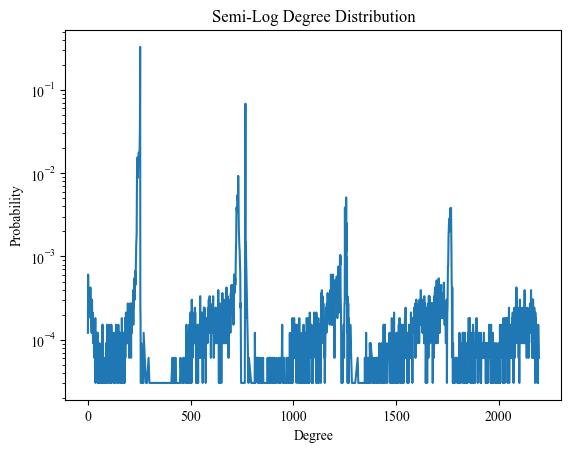

In [ ]:
def plot_degree_histogram(g, normalized=True, semi_log=False):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0, len(aux_y)).tolist()
    n_nodes = g.number_of_nodes()
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i] / n_nodes
    aux_x = [x for x, y in zip(aux_x, aux_y) if y > 0]
    aux_y = [y for y in aux_y if y > 0]
    plt.plot(aux_x, aux_y, markersize=8)
    if semi_log:
        plt.yscale('log')
    plt.title("Semi-Log Degree Distribution" if semi_log else "Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency" if not normalized else "Probability")
    plt.savefig('semi-log-degree-dist-distilbert-tweet-50.png')
    plt.show()

plot_degree_histogram(G, semi_log=True)

Creating histogram...


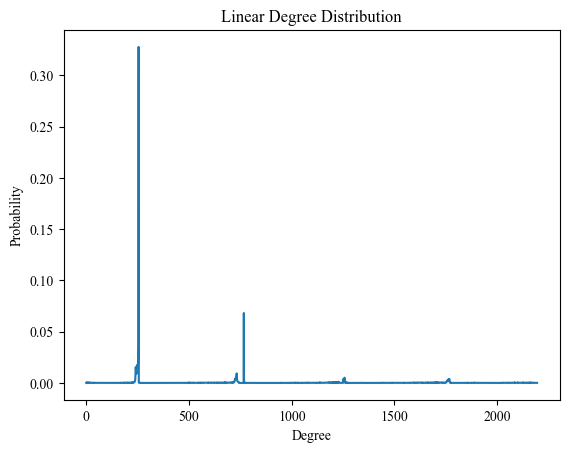

In [ ]:
def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0, len(aux_y)).tolist()
    n_nodes = g.number_of_nodes()
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i] / n_nodes
    plt.plot(aux_x, aux_y, markersize=8)
    plt.title("Linear Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency" if not normalized else "Probability")
    plt.savefig('linear-degree-dist-distilbert-tweet-50.png')
    plt.show()
plot_degree_histogram(G)